In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==============================================================================
# BƯỚC 1: CÀI ĐẶT & IMPORT THƯ VIỆN
# -- Chạy xong bước 1 phải reset session rồi mới import thư viện
# ==============================================================================
!pip install --upgrade scipy scikit-learn pandas --quiet
!pip install transformers datasets sacremoses pysrt underthesea \
             sacrebleu unbabel-comet tqdm accelerate evaluate \
             sentencepiece torch "numpy<2.0.0" --quiet

print("Đã cài đặt xong thư viện!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 151.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 172.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/89

In [ ]:
import os
import glob
import random
import shutil
import pandas as pd
import pysrt
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from underthesea import word_tokenize
import evaluate

In [ ]:
# ==============================================================================
# BƯỚC 2: CẤU HÌNH HỆ THỐNG & ĐƯỜNG DẪN
# ==============================================================================
MAIN_WORKSPACE = '/content/drive/MyDrive/Colab_Notebooks/ITP'
DICT_PATH = os.path.join(MAIN_WORKSPACE, 'workspace', 'chinese-hanviet-cognates.tsv')
MAIN_DATASET_ROOT = os.path.join(MAIN_WORKSPACE, 'data')

# Nơi lưu dữ liệu đã xử lý để dùng lại sau này
DATA_SPLIT_DIR = os.path.join(MAIN_WORKSPACE, 'data_split_netflix-opus')
os.makedirs(DATA_SPLIT_DIR, exist_ok=True)

# Nơi lưu checkpoint và model cuối
OUTPUT_DIR = os.path.join(MAIN_WORKSPACE, 'workspace', "zh-vi-historical-model")
FINAL_MODEL_DIR = os.path.join(MAIN_WORKSPACE, 'workspace', "final_model")

# THAM SỐ ISS (Intelligent Subtitle Segmentation)
ISS_EPSILON = 500  # Sai số cho phép 500ms khi căn chỉnh

# Kiểm tra GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Đã tìm thấy GPU: {torch.cuda.get_device_name(0)}")
    USE_FP16 = True # Dùng GPU thì bật FP16 cho nhanh
else:
    device = torch.device("cpu")
    print("Không tìm thấy GPU, đang chạy trên CPU")
    USE_FP16 = False

Đã tìm thấy GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# ==============================================================================
# BƯỚC 3: HỆ THỐNG ISS (ALIGNMENT) & SBA (AUGMENTATION)
# ==============================================================================

def load_dictionary(file_path):
    print(f"Đang đọc từ điển: {file_path}")
    try:
        df = pd.read_csv(file_path, sep='\t').dropna(subset=['word', 'hanviet'])
        return df['word'].astype(str).tolist(), df['hanviet'].astype(str).tolist()
    except Exception as e:
        print(f"Lỗi đọc từ điển: {e}")
        return [], []

def clean_text(text):
    if not isinstance(text, str): return ""
    return text.replace('\n', ' ').replace('<i>', '').replace('</i>', '').strip()

def align_subtitles_by_time(zh_path, vi_path, epsilon=500):
    try:
        subs_zh = pysrt.open(zh_path, encoding='utf-8')
        subs_vi = pysrt.open(vi_path, encoding='utf-8')
    except Exception as e:
        return [], []

    src_aligned, tgt_aligned = [], []
    vi_idx = 0
    max_vi = len(subs_vi)

    for zh_sub in subs_zh:
        zh_start = zh_sub.start.ordinal
        best_match = None
        min_diff = float('inf')
        temp_idx = vi_idx
        while temp_idx < max_vi:
            vi_sub = subs_vi[temp_idx]
            vi_start = vi_sub.start.ordinal
            diff = abs(zh_start - vi_start)
            if vi_start > zh_sub.end.ordinal + epsilon: break
            if diff <= epsilon:
                if diff < min_diff:
                    min_diff = diff
                    best_match = vi_sub
                    vi_idx = temp_idx
            temp_idx += 1
        if best_match:
            src_aligned.append(clean_text(zh_sub.text))
            tgt_aligned.append(clean_text(best_match.text))
    return src_aligned, tgt_aligned

def sentence_boundary_augmentation(src_list, tgt_list, merge_prob=0.3):
    aug_src, aug_tgt = [], []
    i = 0
    while i < len(src_list):
        if i < len(src_list) - 1 and random.random() < merge_prob:
            s1, s2 = src_list[i], src_list[i+1]
            t1, t2 = tgt_list[i], tgt_list[i+1]
            aug_src.append(s1.rstrip("。，！？…") + " " + s2)
            aug_tgt.append(t1 + " " + t2)
            i += 2
        else:
            aug_src.append(src_list[i])
            aug_tgt.append(tgt_list[i])
            i += 1
    return aug_src, aug_tgt

def process_and_load_data(base_dataset_path, dict_path):
    print(f"Đang quét và chạy ISS Alignment tại: {base_dataset_path}")
    film_src, film_tgt = [], []
    if os.path.exists(base_dataset_path):
        film_dirs = [d.path for d in os.scandir(base_dataset_path) if d.is_dir()]
        for film_dir in tqdm(film_dirs, desc="Processing Films"):
            zh_folder = os.path.join(film_dir, 'zh')
            vi_folder = os.path.join(film_dir, 'vi')
            if not (os.path.exists(zh_folder) and os.path.exists(vi_folder)): continue
            zh_files = glob.glob(os.path.join(zh_folder, "*.srt"))
            for zh_path in zh_files:
                filename = os.path.basename(zh_path)
                file_id = filename.replace("-zh-Hans.srt", "").replace("-zh.srt", "").replace(".srt", "")
                candidates = [f"{file_id}-vi.srt", f"{file_id}.vi.srt"]
                vi_path = None
                for c in candidates:
                    if os.path.exists(os.path.join(vi_folder, c)):
                        vi_path = os.path.join(vi_folder, c)
                        break
                if vi_path:
                    raw_s, raw_t = align_subtitles_by_time(zh_path, vi_path, epsilon=ISS_EPSILON)
                    if raw_s:
                        s_proc, t_proc = sentence_boundary_augmentation(raw_s, raw_t, merge_prob=0.3)
                        film_src.extend(s_proc)
                        film_tgt.extend(t_proc)

    print(f"-> Tổng số câu phim sau xử lý: {len(film_src):,}")
    dict_src, dict_tgt = load_dictionary(dict_path)
    return film_src + dict_src, film_tgt + dict_tgt

In [ ]:
# ==============================================================================
# BƯỚC 4: CHUẨN BỊ DATASET (TRAIN / VALIDATION / TEST)
# ==============================================================================
train_src_path = os.path.join(DATA_SPLIT_DIR, 'train.zh')

# Kiểm tra dữ liệu cũ
if not os.path.exists(train_src_path):
    print("Chưa tìm thấy dữ liệu đã xử lý. Bắt đầu pipeline mới...")
    full_src, full_tgt = process_and_load_data(MAIN_DATASET_ROOT, DICT_PATH)

    if len(full_src) == 0:
        raise ValueError("Không tìm thấy dữ liệu nào! Kiểm tra lại đường dẫn.")

    df = pd.DataFrame({'zh': full_src, 'vi': full_tgt})

    # 1. Chia Train (80%) và Temp (20%)
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

    # 2. Chia Temp thành Validation (10%) và Test (10%)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Lưu 6 file riêng biệt
    def save_split(df, name):
        with open(os.path.join(DATA_SPLIT_DIR, f'{name}.zh'), 'w') as f: f.write('\n'.join(df['zh']))
        with open(os.path.join(DATA_SPLIT_DIR, f'{name}.vi'), 'w') as f: f.write('\n'.join(df['vi']))

    save_split(train_df, 'train')
    save_split(val_df, 'validation')
    save_split(test_df, 'test')

    print(f"Đã chia dữ liệu: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    print("Đã lưu vào folder data_split.")
else:
    print("Tìm thấy dữ liệu cũ, bỏ qua bước xử lý thô.")

# Load vào DatasetDict từ các file riêng biệt
data_files = {
    "train": {"zh": os.path.join(DATA_SPLIT_DIR, 'train.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'train.vi')},
    "validation": {"zh": os.path.join(DATA_SPLIT_DIR, 'validation.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'validation.vi')},
    "test": {"zh": os.path.join(DATA_SPLIT_DIR, 'test.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'test.vi')}
}

def load_custom_dataset():
    def read_txt(path):
        with open(path, 'r', encoding='utf-8') as f: return [l.strip() for l in f]

    return DatasetDict({
        'train': Dataset.from_dict({'zh': read_txt(data_files['train']['zh']), 'vi': read_txt(data_files['train']['vi'])}),
        'validation': Dataset.from_dict({'zh': read_txt(data_files['validation']['zh']), 'vi': read_txt(data_files['validation']['vi'])}),
        'test': Dataset.from_dict({'zh': read_txt(data_files['test']['zh']), 'vi': read_txt(data_files['test']['vi'])})
    })

raw_datasets = load_custom_dataset()
print("Cấu trúc Dataset:", raw_datasets)

Tìm thấy dữ liệu cũ, bỏ qua bước xử lý thô.
Cấu trúc Dataset: DatasetDict({
    train: Dataset({
        features: ['zh', 'vi'],
        num_rows: 358557
    })
    validation: Dataset({
        features: ['zh', 'vi'],
        num_rows: 76834
    })
    test: Dataset({
        features: ['zh', 'vi'],
        num_rows: 76834
    })
})



PHÂN TÍCH ĐỘ DÀI CÂU (SENTENCE LENGTH ANALYSIS)


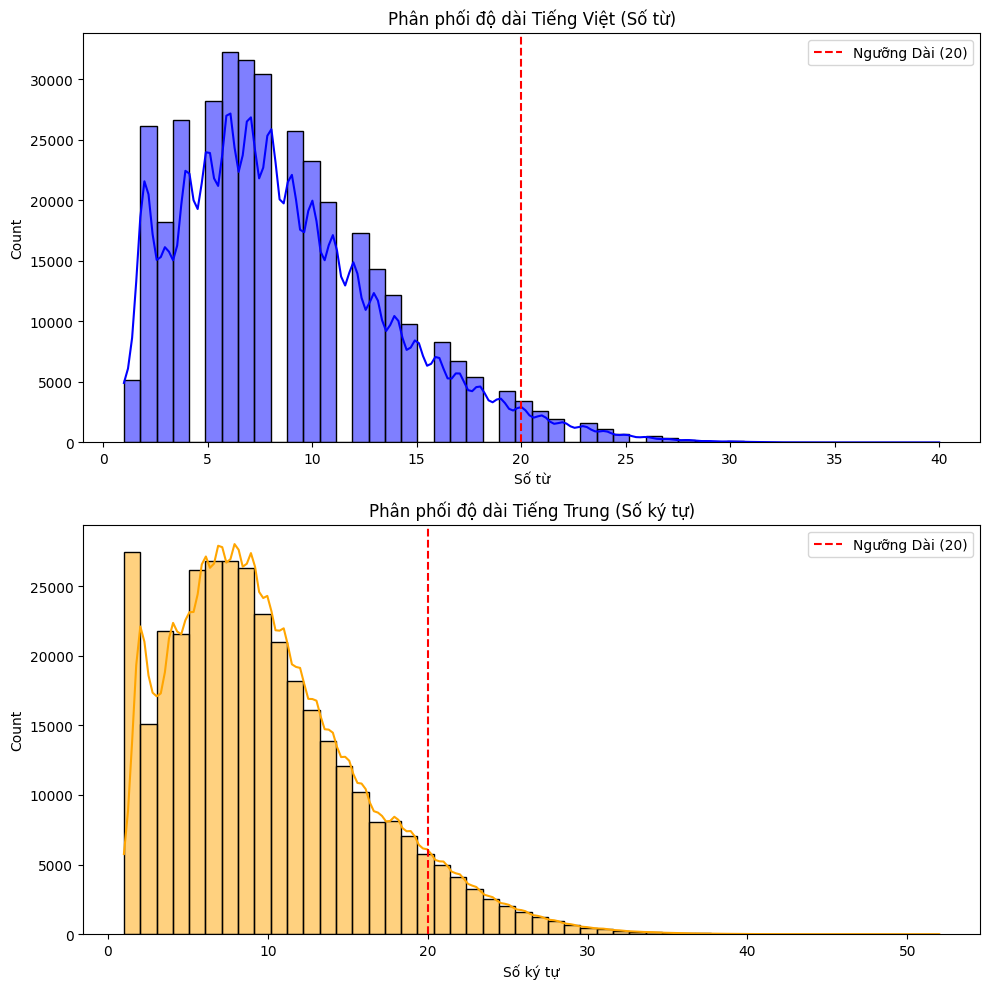


[THỐNG KÊ CHI TIẾT]
Số lượng câu dài (> 20) Tiếng Việt: 9348 / 358557
Số lượng câu dài (> 20) Tiếng Trung: 23152 / 358557


In [ ]:
# ==============================================================================
# TRỰC QUAN HÓA DỮ LIỆU
# ==============================================================================
def visualize_bilingual_data(dataset):
    # Lấy mẫu tập train
    df_vis = pd.DataFrame(dataset['train'][:])

    print("\n" + "="*50)
    print("PHÂN TÍCH ĐỘ DÀI CÂU (SENTENCE LENGTH ANALYSIS)")
    print("="*50)

    # 1. Tính độ dài
    # Tiếng Việt: Đếm số từ (Words)
    df_vis['vi_len'] = df_vis['vi'].astype(str).apply(lambda x: len(x.split()))
    # Tiếng Trung: Đếm số ký tự (Characters)
    df_vis['zh_len'] = df_vis['zh'].astype(str).apply(len)

    # 2. Phân loại (giữ lại phần này cho mục đích thống kê text)
    LONG_THRESHOLD = 20

    def categorize(length):
        if length < 10: return 'Ngắn (<10)'
        elif length <= LONG_THRESHOLD: return f'Trung bình (10-{LONG_THRESHOLD})'
        else: return f'Dài (>{LONG_THRESHOLD})'

    df_vis['cat_vi'] = df_vis['vi_len'].apply(categorize)
    df_vis['cat_zh'] = df_vis['zh_len'].apply(categorize)

    # 3. Vẽ biểu đồ (Chỉ 1 cột histogram cho mỗi ngôn ngữ)
    # Sử dụng subplots với 2 hàng, 1 cột
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # --- Hàng 1: Tiếng Việt ---
    # Hist
    sns.histplot(df_vis['vi_len'], bins=50, kde=True, color='blue', ax=axes[0])
    axes[0].set_title('Phân phối độ dài Tiếng Việt (Số từ)')
    axes[0].axvline(x=LONG_THRESHOLD, color='r', linestyle='--', label=f'Ngưỡng Dài ({LONG_THRESHOLD})')
    axes[0].legend()
    axes[0].set_xlabel('Số từ')

    # --- Hàng 2: Tiếng Trung ---
    # Hist
    sns.histplot(df_vis['zh_len'], bins=50, kde=True, color='orange', ax=axes[1])
    axes[1].set_title('Phân phối độ dài Tiếng Trung (Số ký tự)')
    axes[1].axvline(x=LONG_THRESHOLD, color='r', linestyle='--', label=f'Ngưỡng Dài ({LONG_THRESHOLD})')
    axes[1].legend()
    axes[1].set_xlabel('Số ký tự')

    plt.tight_layout()
    plt.show()

    # In thống kê text
    print(f"\n[THỐNG KÊ CHI TIẾT]")
    print(f"Số lượng câu dài (> {LONG_THRESHOLD}) Tiếng Việt: {len(df_vis[df_vis['vi_len'] > LONG_THRESHOLD])} / {len(df_vis)}")
    print(f"Số lượng câu dài (> {LONG_THRESHOLD}) Tiếng Trung: {len(df_vis[df_vis['zh_len'] > LONG_THRESHOLD])} / {len(df_vis)}")

# Thay thế lệnh gọi hàm cũ bằng hàm mới:
visualize_bilingual_data(raw_datasets)

In [ ]:
# ==============================================================================
# BƯỚC 6: TOKENIZATION & MODEL SETUP
# ==============================================================================
model_checkpoint = "Helsinki-NLP/opus-mt-zh-vi"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    model_inputs = tokenizer(examples["zh"], max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["vi"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True, load_from_cache_file=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/750k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/766k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Map:   0%|          | 0/358557 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

Map:   0%|          | 0/76834 [00:00<?, ? examples/s]

Map:   0%|          | 0/76834 [00:00<?, ? examples/s]

In [ ]:
# ==============================================================================
# Chỉ chạy khi muốn training lại mô hình
# ==============================================================================
import shutil
import os

# 1. Xác định thư mục chứa checkpoint
output_dir_path = OUTPUT_DIR

# 2. Xóa toàn bộ thư mục output cũ để đảm bảo sạch sẽ 100%
if os.path.exists(output_dir_path):
    try:
        print(f"   -> Đang xóa thư mục cũ: {output_dir_path}")
        shutil.rmtree(output_dir_path) # Lệnh này xóa cực mạnh, xóa cả folder con
        print("   -> Đã xóa sạch thành công!")
    except Exception as e:
        print(f"   -> Không xóa được (Lỗi quyền hoặc Drive): {e}")
else:
    print("   -> Thư mục đã sạch hoặc chưa tồn tại, không cần xóa.")

# 3. Tạo lại thư mục rỗng
os.makedirs(output_dir_path, exist_ok=True)
print(f"   -> Đã tạo thư mục mới tại: {output_dir_path}")

   -> Đang xóa thư mục cũ: /content/drive/MyDrive/Colab_Notebooks/ITP/workspace/zh-vi-historical-model
   -> Đã xóa sạch thành công!
   -> Đã tạo thư mục mới tại: /content/drive/MyDrive/Colab_Notebooks/ITP/workspace/zh-vi-historical-model


In [ ]:
# ==============================================================================
# BƯỚC 7: TRAINING (ĐÃ SỬA LỖI TÊN THAM SỐ)
# ==============================================================================

def clean_checkpoint_for_resume(output_dir):
    checkpoints = glob.glob(os.path.join(output_dir, "checkpoint-*"))
    if not checkpoints: return None
    latest_ckpt = max(checkpoints, key=os.path.getctime)
    print(f"Đang kiểm tra checkpoint: {latest_ckpt}")
    garbage_files = ["scaler.pt", "rng_state.pth"]
    for gf in garbage_files:
        path = os.path.join(latest_ckpt, gf)
        if os.path.exists(path):
            try:
                os.remove(path)
                print(f"   -> Đã xóa file gây lỗi: {gf}")
            except: pass
    return latest_ckpt

# Cấu hình Train
args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",

    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    weight_decay=0.02,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=USE_FP16, # Tự động bật tắt theo GPU
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"], # Đánh giá trên file Validation
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[early_stopping]
)

/tmp/ipython-input-3609196577.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Tự động tìm và sửa checkpoint trước khi train
resume_ckpt = clean_checkpoint_for_resume(OUTPUT_DIR)

print("\nBẮT ĐẦU HUẤN LUYỆN...")
trainer.train(resume_from_checkpoint=resume_ckpt)

Đang kiểm tra checkpoint: /content/drive/MyDrive/Colab_Notebooks/ITP/workspace/zh-vi-historical-model/checkpoint-11205


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.



BẮT ĐẦU HUẤN LUYỆN...


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


Epoch,Training Loss,Validation Loss
2,1.950800,1.862709
3,1.872000,1.838735


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


TrainOutput(global_step=33615, training_loss=1.2826676449427448, metrics={'train_runtime': 10392.8883, 'train_samples_per_second': 103.501, 'train_steps_per_second': 3.234, 'total_flos': 3603127388405760.0, 'train_loss': 1.2826676449427448, 'epoch': 3.0})

In [ ]:
# # ==============================================================================
# # BƯỚC 8: LƯU & ĐÁNH GIÁ TRÊN TẬP TEST VÀ VALIDATION
# # ==============================================================================
# print("\nĐANG LƯU MODEL...")
# trainer.save_model(FINAL_MODEL_DIR)
# tokenizer.save_pretrained(FINAL_MODEL_DIR)

# print("\nĐANG ĐÁNH GIÁ...")
# bleu_metric = evaluate.load("sacrebleu")

# def compute_metrics_final(model, dataset, name="Tập dữ liệu"):
#     print(f"\n--- Đang tính BLEU cho {name} ---")
#     # Lấy mẫu ngẫu nhiên n câu để test nhanh
#     # sample_ds = dataset.shuffle(seed=42).select(range(min(76887, len(dataset))))
#     sample_ds = dataset.shuffle(seed=42)

#     preds = trainer.predict(sample_ds)
#     decoded_preds = tokenizer.batch_decode(preds.predictions, skip_special_tokens=True)
#     decoded_labels = tokenizer.batch_decode(preds.label_ids, skip_special_tokens=True)

#     seg_preds = [" ".join(word_tokenize(p, format="text").split()) for p in decoded_preds]
#     seg_labels = [[" ".join(word_tokenize(l, format="text").split())] for l in decoded_labels]

#     res = bleu_metric.compute(predictions=seg_preds, references=seg_labels)
#     print(f"Result for {name}: {res['score']:.2f}")
#     return res['score']

# # Đánh giá trên cả 2 tập
# score_val = compute_metrics_final(model, tokenized_datasets['validation'], name="VALIDATION SET")
# score_test = compute_metrics_final(model, tokenized_datasets['test'], name="TEST SET")

# print(f"\n>>> TỔNG KẾT:")
# print(f"BLEU Validation: {score_val:.2f}")
# print(f"BLEU Test:       {score_test:.2f}")


ĐANG LƯU MODEL...


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



ĐANG ĐÁNH GIÁ...



--- Đang tính BLEU cho VALIDATION SET ---


KeyboardInterrupt: 

In [ ]:
# ==============================================================================
# BƯỚC 8: LƯU & ĐÁNH GIÁ (CÓ CƠ CHẾ CHECKPOINT & RESUME)
# ==============================================================================
import json
import os

# --- CẤU HÌNH CHECKPOINT ---
EVAL_RESULT_FILE = os.path.join(MAIN_WORKSPACE, 'eval_results.json')
FORCE_RE_EVALUATE = False  # Đổi thành True nếu bạn muốn bắt buộc tính lại từ đầu

# Xóa file kết quả cũ nếu muốn chạy lại
if FORCE_RE_EVALUATE and os.path.exists(EVAL_RESULT_FILE):
    os.remove(EVAL_RESULT_FILE)
    print("!!! Đã xóa checkpoint đánh giá cũ. Sẽ tính toán lại toàn bộ.")

# Hàm đọc/ghi kết quả
def load_saved_results():
    if os.path.exists(EVAL_RESULT_FILE):
        try:
            with open(EVAL_RESULT_FILE, 'r') as f:
                return json.load(f)
        except: return {}
    return {}

def save_result(key, score):
    data = load_saved_results()
    data[key] = score
    with open(EVAL_RESULT_FILE, 'w') as f:
        json.dump(data, f)
    print(f"-> Đã lưu kết quả '{key}' vào file.")

In [ ]:
print("\nĐANG LƯU MODEL...")
# Chỉ lưu nếu chưa tồn tại để tiết kiệm thời gian (hoặc bạn có thể giữ nguyên để lưu đè)
if not os.path.exists(FINAL_MODEL_DIR):
    trainer.save_model(FINAL_MODEL_DIR)
    tokenizer.save_pretrained(FINAL_MODEL_DIR)
    print("-> Đã lưu model thành công.")
else:
    print("-> Model đã tồn tại, bỏ qua bước lưu.")

print("\nĐANG ĐÁNH GIÁ...")
bleu_metric = evaluate.load("sacrebleu")

def compute_metrics_final(model, dataset, key_name, display_name="Tập dữ liệu"):
    # 1. Kiểm tra xem đã có kết quả chưa
    saved_data = load_saved_results()
    if key_name in saved_data and not FORCE_RE_EVALUATE:
        print(f"\n--- Đã tìm thấy kết quả cũ cho {display_name} ---")
        score = saved_data[key_name]
        print(f"Result for {display_name} (Loaded): {score:.2f}")
        return score

    # 2. Nếu chưa có thì tính toán
    print(f"\n--- Đang tính BLEU cho {display_name} ---")

    # Dùng toàn bộ dataset (đã shuffle)
    sample_ds = dataset

    # Chạy predict (Cẩn thận OOM, đảm bảo batch size eval thấp: 4 hoặc 8)
    preds = trainer.predict(sample_ds)
    decoded_preds = tokenizer.batch_decode(preds.predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(preds.label_ids, skip_special_tokens=True)

    seg_preds = [" ".join(word_tokenize(p, format="text").split()) for p in decoded_preds]
    seg_labels = [[" ".join(word_tokenize(l, format="text").split())] for l in decoded_labels]

    res = bleu_metric.compute(predictions=seg_preds, references=seg_labels)
    score = res['score']

    print(f"Result for {display_name}: {score:.2f}")

    # 3. Lưu ngay lập tức
    save_result(key_name, score)

    return score

# Đánh giá lần lượt (Có cơ chế Resume)
# Lưu ý: 'val_score' và 'test_score' là key để lưu trong file json
score_val = compute_metrics_final(model, tokenized_datasets['validation'], key_name="val_score", display_name="VALIDATION SET")
score_test = compute_metrics_final(model, tokenized_datasets['test'], key_name="test_score", display_name="TEST SET")

print(f"\n>>> TỔNG KẾT:")
print(f"BLEU Validation: {score_val:.2f}")
print(f"BLEU Test:       {score_test:.2f}")


ĐANG LƯU MODEL...
-> Model đã tồn tại, bỏ qua bước lưu.

ĐANG ĐÁNH GIÁ...



--- Đã tìm thấy kết quả cũ cho VALIDATION SET ---
Result for VALIDATION SET (Loaded): 11.66

--- Đang tính BLEU cho TEST SET ---


Result for TEST SET: 11.66
-> Đã lưu kết quả 'test_score' vào file.

>>> TỔNG KẾT:
BLEU Validation: 11.66
BLEU Test:       11.66


In [ ]:
# ==============================================================================
# BƯỚC 9: KIỂM TRA THỰC TẾ (DEMO & VISUALIZATION)
# ==============================================================================
from transformers import pipeline

print("\n" + "="*50)
print("DEMO KẾT QUẢ DỊCH THỰC TẾ")
print("="*50)

# 1. Khởi tạo Pipeline dịch thuật (Sử dụng model vừa train xong)
translator = pipeline(
    "translation",
    model=FINAL_MODEL_DIR,
    tokenizer=FINAL_MODEL_DIR,
    device=0 if torch.cuda.is_available() else -1 # Chạy trên GPU nếu có
)

# 2. Lấy ngẫu nhiên 10 mẫu từ tập Test (Dữ liệu gốc chưa tokenized)
# Lưu ý: Dùng raw_datasets để lấy chữ đọc được, không dùng tokenized_datasets
sample_indices = random.sample(range(len(raw_datasets['test'])), 10)
samples = raw_datasets['test'].select(sample_indices)

# 3. Thực hiện dịch và so sánh
results = []
print("Đang dịch thử các mẫu ngẫu nhiên...")

for item in tqdm(samples):
    src_text = item['zh']
    ref_text = item['vi']

    # Máy dịch
    pred_text = translator(src_text)[0]['translation_text']

    results.append({
        "Tiếng Trung (Input)": src_text,
        "Tiếng Việt (Người dịch)": ref_text,
        "Tiếng Việt (Mô hình dịch)": pred_text
    })

# 4. Hiển thị bảng kết quả
df_results = pd.DataFrame(results)

# Cấu hình pandas để hiển thị hết nội dung dài
pd.set_option('display.max_colwidth', None)

# Hiển thị bảng
from IPython.display import display, HTML
print("\n>>> BẢNG SO SÁNH KẾT QUẢ:")
display(df_results)

# 5. Lưu kết quả ra Excel/CSV để làm báo cáo
df_results.to_csv(os.path.join(MAIN_WORKSPACE, 'ket_qua_dich_thuc_te.csv'), index=False)
print(f"\nĐã lưu file kết quả mẫu tại: {os.path.join(MAIN_WORKSPACE, 'ket_qua_dich_thuc_te.csv')}")


DEMO KẾT QUẢ DỊCH THỰC TẾ


Device set to use cuda:0


Đang dịch thử các mẫu ngẫu nhiên...


  0%|          | 0/10 [00:00<?, ?it/s]


>>> BẢNG SO SÁNH KẾT QUẢ:


,Tiếng Trung (Input),Tiếng Việt (Người dịch),Tiếng Việt (Mô hình dịch)
0,好累啊 阿珠,"A Châu à, mệt quá.","Em mệt quá, Juju."
1,爱上人族 有害无益 人心最为复杂 最为多变,"Động lòng với Nhân tộc, chỉ có hại, chẳng được lợi lộc gì. Lòng người phức tạp và dễ đổi thay nhất.","Tình yêu con người, sự kết hợp vô hại, phức tạp nhất, phức tạp nhất trên thế giới."
2,没有想到,"Không ngờ mọi người có thể kiếm nhiều tiền như vậy,",Tôi không nghĩ tới chuyện đó.
3,别让人久等了 高修士 是吧？,đừng để người ta chờ lâu. Cao tu sĩ phải không?,"Đừng để ai chờ nữa, tiến sĩ Cross, phải không?"
4,你们,Các người…,Các người!
5,走 多谢上神为小儿诊病,Đi nào. Tạ ơn thượng thần,Cảm ơn Chúa vì bệnh nhi.
6,蓝湛 你这 蓝湛这个驴脾气,"Lam Trạm, ngươi... Lam Trạm đúng là tên cứng đầu.",Ngươi là một tên phù thủy độc ác.
7,-仙使 -仙使,Tiên sứ.,Tiên pháp.
8,她李未央哪点比我好？,Lý Vị Ương đó có điểm gì tốt hơn ta?,Tại sao cô ấy lại tốt hơn tôi?
9,你不能跟着我,Muội không thể đi theo ta.,Anh không thể đi theo tôi.



Đã lưu file kết quả mẫu tại: /content/drive/MyDrive/Colab_Notebooks/ITP/ket_qua_dich_thuc_te.csv


In [ ]:
# ==============================================================================
# BƯỚC 10: THỬ NGHIỆM TỰ NHẬP CÂU (INTERACTIVE DEMO)
# ==============================================================================
print("\n" + "="*50)
print("THỬ NGHIỆM: BẠN NHẬP - MÁY DỊCH")
print("="*50)

def translate_sentence(sentence):
    pred = translator(sentence)[0]['translation_text']
    print(f"🇨🇳 Trung: {sentence}")
    print(f"🇻🇳 Việt : {pred}")
    print("-" * 30)

# Thử vài câu kinh điển
custom_sentences = [
    "皇上，臣妾真的不知道该怎么办了。", # Hoàng thượng, thần thiếp thật sự không biết phải làm sao.
    "大胆奴才，竟然敢欺骗朕！", # Tên nô tài to gan, dám lừa gạt Trẫm!
    "若有来生，我不愿再入帝王家。", # Nếu có kiếp sau, ta không muốn vào nhà đế vương nữa.
    "师兄，我们一起下山吧。", # Sư huynh, chúng ta cùng xuống núi đi.
    "陛下，若是您执意不念旧情，非要赐死萧将军，那么臣妾也绝不独活，愿随他一同赴黄泉。",
    "师兄，杀师之仇不共戴天，今日若不取这恶贼的狗命祭奠师父在天之灵，我有何颜面去见列祖列宗！",
    "启禀大将军，如今敌军兵临城下，城中粮草已尽，若三日之内没有援兵赶到，恐怕我们要全军覆没在这孤城之中了。",
    "哪怕全天下的人都背叛你，我也会在你身后背叛全世界，只要能护你一世周全，我便死而无憾。"
]

for s in custom_sentences:
    translate_sentence(s)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



THỬ NGHIỆM: BẠN NHẬP - MÁY DỊCH
🇨🇳 Trung: 皇上，臣妾真的不知道该怎么办了。
🇻🇳 Việt : Hoàng thượng, tiểu thư đây thật sự không biết phải làm gì nữa.
------------------------------
🇨🇳 Trung: 大胆奴才，竟然敢欺骗朕！
🇻🇳 Việt : Nô tài dám lừa trẫm
------------------------------
🇨🇳 Trung: 若有来生，我不愿再入帝王家。
🇻🇳 Việt : Nếu có con, ta sẽ không vào nhà của nhà vua nữa.
------------------------------
🇨🇳 Trung: 师兄，我们一起下山吧。
🇻🇳 Việt : Sư huynh, chúng ta cùng xuống núi đi.
------------------------------
🇨🇳 Trung: 陛下，若是您执意不念旧情，非要赐死萧将军，那么臣妾也绝不独活，愿随他一同赴黄泉。
🇻🇳 Việt : Nếu ngài không muốn từ bỏ tình cảm của mình, thì thần sẽ không sống một mình trên con suối với hắn đâu.
------------------------------
🇨🇳 Trung: 师兄，杀师之仇不共戴天，今日若不取这恶贼的狗命祭奠师父在天之灵，我有何颜面去见列祖列宗！
🇻🇳 Việt : Sư huynh, giết sư phụ không cùng thiên địa, hôm nay nếu không lấy mạng con chó của tên trộm này hiến tế sư phụ, tại sao ta lại phải gặp vinh quang?
------------------------------
🇨🇳 Trung: 启禀大将军，如今敌军兵临城下，城中粮草已尽，若三日之内没有援兵赶到，恐怕我们要全军覆没在这孤城之中了。
🇻🇳 Việt : Xin Đại tướng thứ lỗi, q